# Analyzing patterns of successful games

<b>Table of contents</b>

1. [Introduction](#introduction)
2. [General information](#general)
    * [Conclusion](#conclusion1)
3. [Data preprocessing](#preprocessing)
    * [Missing values](#missing)
    * [Duplicates](#duplicates)
    * [Data types conversion](#conversion)
    * [Calculations](#calculations)
    * [Conclusion](#conclusion2)
4. [Data analysis](#analysis)
    * [Analysis of number of games per year](#n-games)
    * [Analysis of sales per platform](#platforms)
    * [Influence of user and critic scores on sales per platform](#scores)
    * [Analysis of genres](#genres)
    * [Conclusion](#conclusion3)
5. [User profiles](#user-profile)
    * [Conclusion](#conclusion4)
6. [Hypotheses testing](#hypotheses)
    * [Conclusion](#conclusion5)
7. [Overall conclusion](#conclusion6)

<a id="introduction"></a>
## Introduction

<b>Project description</b>

In this project we're going to analyze patterns of successful games for online gaming store Ice to learn how to predict which games will be successful in future.  This will allow us to spot potential big winners and plan advertising campaigns. We're evaluating data that goes back to 2016.

<B>Project structure</b>

1. We're going to take a general look at the data.
2. Data preparation (handling missing values, calculations etc)
3. Data analysis (sales per platforms, genres, user and critic scores)
4. Creating a user profile per region (analyzing platforms, genres and ratings per region)
5. Testing hypotheses
6. General conclusion

<a id="general"></a>
## General information

In [1]:
!pip install -Uq sidetable
!pip install -Uq seaborn

*Note: be sure to update these packages, otherwise some blocks won't work.*

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import sidetable
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from io import BytesIO
import requests

In [3]:
try:
    data = pd.read_csv('games.csv')
except:    
    print('Error while loading the file')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Conclusion*: Our dataset contains 16715 entries and 11 columns: 6 float type and 5 object type. As we can see already from info() method there are some visible issues:
<br>`Name`: 2 missing names
<br>`Year_of_Release`: has 269 missing values. 
<br>`Genre`: has 2 missing values, perhaps the same rows that the name.
<br>`Critic_score`: half of the data is missing.
<br>`User_score`: has 6001 missing values. Also it is an object type, we'll need to check the reason why.
<br>`Rating`: also has 6766 missing values and also is an object type.

Overall there's some valuble data missing, considering we need scoring and rating to study the patterns. Also some column names can be renamed (to lowercase) and data types changed.

In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
data.describe(include=['object'])

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


*Conclusion*: 
* The minimum value for `Year_of_Release` is 1980, there are some indeed old games included in this dataset.
* All sales have 0 as minimum value from what we can guess that not all games were sold in all regions.
* There are 11559 unique values out of 16713 in `name` column, which probably doesn't mean they're duplicates, but that quite a lot of games came out several different years, which happens in game industry. We also can see an example of such case - a game that almost anybodycan recognize, NFS.
* in `user_score` we see that the most frequent value is 'tbd', which is probably the reason for it being an object type.

In [7]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
data.tail()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


In [9]:
data.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16008,Sengoku Efuda Yuugi: Hototogisu Ran,PSP,2008.0,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
1946,Worms Armageddon,PS,1999.0,Strategy,0.18,0.81,0.00,0.08,NaN,NaN,NaN
8840,J-League Victory Goal,SAT,1995.0,Sports,0.00,0.00,0.15,0.00,NaN,NaN,NaN
6430,The Incredible Hulk,X360,2008.0,Action,0.22,0.02,0.00,0.02,55.0,6.4,T
3717,Hotel Dusk: Room 215,DS,2007.0,Adventure,0.26,0.04,0.22,0.03,78.0,8.6,T
14156,Tomb Raider: Anniversary,PC,2007.0,Action,0.00,0.03,0.00,0.01,83.0,8.1,T
14936,Open Season,PS2,2006.0,Platform,0.01,0.01,0.00,0.00,57.0,tbd,E10+
16326,Victory Spike,PS,1996.0,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN
9875,Kidz Sports: Crazy Golf,Wii,2008.0,Sports,0.11,0.00,0.00,0.01,NaN,3.4,E
14967,Senjou no Waltz,PSV,2014.0,Adventure,0.00,0.00,0.03,0.00,NaN,NaN,NaN


*Conclusion*:
* Looking at sales columns from head() and tail() methods it looks like the data is sorted. 
* `Critic_score` and `User_score` have different scales. If it turns out to be problematic in future we can try to change one of them. As it seems too far-fetched to get precise level of scores by multiplying by 10 in case of `User_score` it is probably a better idea to devide `Critic_score` by 10. 

<a id="conclusion1"></a>
### Conclusion

We have a relatively small dataset containing less than 20000 rows and 11 columns. We've spotted some missing data in several columns: from 2 datapoints to half of the data missing in one column. List of spotted issues:

* `Name` and `Genre` have 2 missing values in each, probably in the same rows. If so, we can drop them.
* `Critic_score`, `User_score` and `Rating` all have considerable amount of missing data.
* `User_score` will be better to have as numeric type..
* `Critic_score` and `User_score` can be turned to the same scale if we need it, in that case it is a must to change the type of `User_score` to numeric.
* Columns better be renamed to make them lower case.
* `Genre` we'll check to make sure we don't have synonyms or duplicates.
* `Year_of_Release` has some data missing, doesn't look like it's a lot. Also it is float and for convinience we can change it to int, depending on how we'll deal with missing values.

<a id="preprocessing"></a>
## Data preprocessing

<a id="missing"></a>
### Missing values

Before we proceed with dealing with missing values, let's change column names to lowercase.

In [10]:
data.columns = data.columns.str.lower()

In [11]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Now to our missing values. We'll start with taking a look at a sidetable to check the exact percents of missing data. For that we'll use a sidetable method - missing. 

In [12]:
data.stb.missing(style=True)

,missing,total,percent
critic_score,"8,578","16,715",51.32%
rating,"6,766","16,715",40.48%
user_score,"6,701","16,715",40.09%
year_of_release,269,"16,715",1.61%
name,2,"16,715",0.01%
genre,2,"16,715",0.01%
platform,0,"16,715",0.00%
na_sales,0,"16,715",0.00%
eu_sales,0,"16,715",0.00%
jp_sales,0,"16,715",0.00%


As we previously saw the greatest amount of missing data is in `critic_score`, followed closely by `rating` and `user_score`. `year_of_release` has less than 2% of missing values, so whether we fill it in or leave it as it is won't be critical. `name` and `genre` are obviously the least critical being only 2 rows. Let's start with them. 

Let's check whether missing data from `name` and `genre` is from the same rows. If so, we'll drop them.

In [13]:
data[data['name'].isnull() == 1]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Interesting is that hey are for the same platform and same year of release, perhaps it is the same game, but we don't have a way to check that. This looks like an error in the process of building this dataset. We can drop these rows.

In [14]:
data = data[data['name'].isnull() == 0]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Next, let's check `year_of_release`.

In [16]:
data[data['year_of_release'].isnull() == 1]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


*Conclusion*: This data seems to be missing completely at random. Year of release is categorical ordinal data, we can't know for sure what year the game was released just from its name. When we see year in the name it could be the year of release or this game was remastered - we don't know. In our case it is 1.6% of the data, we can delete these rows or leave them as they are. 

One of the steps in this research will be creating a sample based on this variable and proceeding with research while working with a said sample, so as by filling the missing data with 0 we still won't be able to use it for creating a sample, we can drop them.

In [17]:
data = data[data['year_of_release'].isnull() == 0]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In the next part we need to deal with sensitive data, so we've found an additional dataset, that will help us to fill in some missing data in `rating`, `user_score` and `critic_score`. Though probably it won't help us a lot, still it's the most precise way to get rid of at least some of the missing values.

The source: https://www.kaggle.com/mohammedali10/metacritic-games-of-all-time

Before we proceed we'll take a closer look at these columns to better understand the nature of missing data.

At first, let's take a look at missing data in `user_score`. Before that we'll check the updated sidetable of missing values.

In [19]:
data.stb.missing(style=True)

,missing,total,percent
critic_score,"8,461","16,444",51.45%
rating,"6,676","16,444",40.60%
user_score,"6,605","16,444",40.17%
name,0,"16,444",0.00%
platform,0,"16,444",0.00%
year_of_release,0,"16,444",0.00%
genre,0,"16,444",0.00%
na_sales,0,"16,444",0.00%
eu_sales,0,"16,444",0.00%
jp_sales,0,"16,444",0.00%


There's more data missing in `critic_score` than in `user_score`. We want to check the hypothesis that the missing data in `user_score` is from the same rows that have missing values in `critic_score`. If it turns out to be true, perhaps there was some kind of an error at the step of creating the dataset, as we know that user scoring is a result of individual users' experience and has different origin than critic scoring, meaning there have to be cases when the games that didn't receive critic scoring, did receive attention among users.

In [20]:
len(data[(data['critic_score'].isnull() == 1) & (data['user_score'].isnull() == 1)])

6572

*Conclusion*: As we can see, same as with `year_of_release` this hypothesis can be rejected. This confirms that the data is naturally missing and it's not an error. Overall user score is something depending on user experience and user's desire to leave feedback, which usually happens when they want to thank the creators or to express their displeasure. From describe() method before we also spotted the reason why this column is an object type: we have <b>'tbd'</b> value, which stands for <b>'to be determined'</b>. If we could we would have consulted how this value was created for this particular dataset. As we don't have the way to do that, our guess is that there needs to be a certain number of reviews to calculate the average score. Perhaps those games were less popular and didn't receive many reviews among users. 

* checking on Metacritic website https://www.metacritic.com/faq#item13 we've found the proof of this theory: it is said that the score isn't determined unless 4 reviews have been submitted.

For us in this research, this has the same meaning as missing values because we can't know what the future score will be. Overall this data depends too much on user's opinion and same as `critic_score` can't be substituted by mean or median in such quantity. Although there may be some influence or relation between `critic_score` and `user_score`, it depends and deserves research of its own. In our experience even the worst judged games by critics can become popular among users and vice versa. We also think that substituting this data by 0 isn't the best choice as it can be understood as a low scoring. It is best to leave this data as it is. On the other hand, we need to convert `user_score` to numeric type and we can't do it with 'tbd' value present, but as we're going to try to restore some data from an external dataset, we have to treat them twice: before filling na and after (there's a chance that the dataset we've found had already updated this status, but if so, probably not in all cases).

In [21]:
data[data['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [22]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Let's check whether the code was performed correctly by taking a look at one of the games from above:

In [23]:
data[data['name'] == 'Planet Monsters']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.0,0.0,0.0,67.0,NaN,E


In [24]:
data['user_score'].value_counts()

7.8    322
8      285
8.2    276
8.3    252
7.5    249
      ... 
1.5      2
0.3      2
1.1      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

Now, let's check `critic_score`. Perhaps the missing values are all from new games or all the really old games that didn't receive critic scoring. Other hypothesis is that not all games receive critic scoring in the first place.

In [25]:
data[data['critic_score'].isnull() == 1]['year_of_release'].value_counts().sort_index()

1980.0      9
1981.0     46
1982.0     36
1983.0     17
1984.0     14
1985.0     13
1986.0     21
1987.0     16
1988.0     14
1989.0     17
1990.0     16
1991.0     41
1992.0     42
1993.0     60
1994.0    120
1995.0    219
1996.0    255
1997.0    272
1998.0    351
1999.0    299
2000.0    207
2001.0    156
2002.0    202
2003.0    190
2004.0    201
2005.0    284
2006.0    386
2007.0    505
2008.0    712
2009.0    775
2010.0    755
2011.0    636
2012.0    332
2013.0    271
2014.0    320
2015.0    381
2016.0    270
Name: year_of_release, dtype: int64

As we can see the hypothesis that those are new games turned out to be wrong. Probably it means that these games didn't get critic scoring at all. If so we consider it wrong to fill in this data with mean or median, as it will distort the reality.

Next we'll take a look at `rating` column.

In [26]:
data[data['rating'].isnull() == 0].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
11,Mario Kart DS,DS,2005.0,Racing,9.71,7.47,4.13,1.90,91.0,8.6,E
13,Wii Fit,Wii,2007.0,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E
15,Wii Fit Plus,Wii,2009.0,Sports,9.01,8.49,2.53,1.77,80.0,7.4,E


In [27]:
data[data['rating'].isnull() == 1].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
18,Super Mario World,SNES,1990.0,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN
21,Super Mario Land,GB,1989.0,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN
22,Super Mario Bros. 3,NES,1988.0,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN


There are a lot of old games in our sample, let's check `year_of_release` values for missing data in `rating`.

In [28]:
data[data['rating'].isnull() == 1]['year_of_release'].value_counts()

2010.0    456
2008.0    446
2011.0    433
2009.0    415
2007.0    376
1998.0    347
2006.0    328
2012.0    298
1999.0    296
2015.0    291
1997.0    270
1996.0    256
2014.0    236
2005.0    233
2013.0    228
2016.0    222
1995.0    219
2000.0    202
2002.0    174
2004.0    164
2003.0    162
2001.0    143
1994.0    120
1993.0     60
1981.0     46
1992.0     41
1991.0     41
1982.0     36
1986.0     21
1983.0     17
1989.0     17
1990.0     16
1987.0     16
1988.0     14
1984.0     14
1985.0     13
1980.0      9
Name: year_of_release, dtype: int64

In [29]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

*Conclusion*: We've checked whether there's some kind of a pattern in data missing depending on year of release and this doesn't seem to be the case.

As we can see this rating belongs to ESRB organization's content rating system. ESRB is used in USA, Canada and Mexico, so we have to take into account that origin of the game matters in receiving the rating. There's a chance we have only ESRB ratings in this dataset. This rating uncludes 2 former ratings (K-A and EC) and 6 modern. Meanings:
 - E stands for 'everybody'
 - T for 'teen'
 - M for 'mature'
 - E10+ for 'everyone 10+'
 - RP for 'rating pending'
 - AO for 'adults only'
 - K-A for 'kids to adults' (same as E)
 - EC for 'early childhood' (or preschool children)

This is categorical data, and the usual approach to fill in the missing data will be using mode, but we consider it wrong to do so in our case, as it is highly difficult to predict game's rating based solely on its name or genre, as the same game, coming out each year can receive update of its rating(e.g. usually creators improve their game if they remaster it, so the contents of the game may change, or they may add additional storylines etc). In this case, however, we'll fill missing values with 'Unknown', as whether there was no rating from the beginning or there was but of different origin - we can't know for sure. 

But before that we'll restore the data that we can restore from external dataset.

Now let's upload external dataset.

In [30]:
spreadsheet_id = '1g8HhcToTqxm8DzUzRB75lehw8OaS5fPDmgPGny0-cqg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14666 entries, 0 to 14665
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    14666 non-null  int64  
 1   title         14666 non-null  object 
 2   release       14666 non-null  object 
 3   platform      14666 non-null  object 
 4   critic_score  14659 non-null  float64
 5   user_score    14658 non-null  object 
 6   developer     14666 non-null  object 
 7   genre(s)      14666 non-null  object 
 8   rating        12616 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.0+ MB


In [32]:
df.head(10)

,Unnamed: 0,title,release,platform,critic_score,user_score,developer,genre(s),rating
0,1,Portal 2,2011-04-19,Xbox 360,95.0,8.8,Valve Software,"Action,Shooter,Shooter,First-Person,Sci-Fi,Sci...",E10+
1,2,Metal Gear Solid V: The Phantom Pain,2015-09-01,Xbox One,95.0,7.5,Konami,"Modern,Modern,Action Adventure,Open-World",M
2,3,Red Dead Redemption,2010-05-18,Xbox 360,95.0,9,Rockstar Games,"Action,Action Adventure,Shooter,Historic,Histo...",M
3,4,Portal 2,2011-04-18,PC,95.0,9.1,Valve Software,"Action,Shooter,Shooter,First-Person,Sci-Fi,Sci...",E10+
4,5,The Last of Us Remastered,2014-07-29,PlayStation 4,95.0,9.2,SCEA,"Action Adventure,General,Modern",M
5,6,Persona 5 Royal,2020-03-31,PlayStation 4,95.0,8.4,Atlus,"Role-Playing,Japanese-Style",M
6,9,The Last of Us,2013-06-14,PlayStation 3,95.0,9.2,SCEA,"Modern,Adventure,General,Action Adventure,Gene...",M
7,13,Gran Turismo 3: A-Spec,2001-07-09,PlayStation 2,95.0,8.5,SCEA,"Driving,Racing,GT / Street",E
8,14,Red Dead Redemption,2010-05-18,PlayStation 3,95.0,8.9,Rockstar Games,"Action,Shooter,Third-Person,Historic,Action Ad...",M
9,15,Madden NFL 2003,2002-08-12,PlayStation 2,95.0,7.5,EA Sports,"Sports,Traditional,Football,Sim",E


In this dataset at first we need to create a `year_of_release` column, and change `title` to `name` as those are our identificator columns.

In [33]:
date_format = '%Y-%m-%d'
df['year_of_release'] = pd.DatetimeIndex(pd.to_datetime(df['release'], format=date_format)).year

In [34]:
df.rename(columns={'title':'name'}, inplace=True)

In [35]:
df.head()

,Unnamed: 0,name,release,platform,critic_score,user_score,developer,genre(s),rating,year_of_release
0,1,Portal 2,2011-04-19,Xbox 360,95.0,8.8,Valve Software,"Action,Shooter,Shooter,First-Person,Sci-Fi,Sci...",E10+,2011
1,2,Metal Gear Solid V: The Phantom Pain,2015-09-01,Xbox One,95.0,7.5,Konami,"Modern,Modern,Action Adventure,Open-World",M,2015
2,3,Red Dead Redemption,2010-05-18,Xbox 360,95.0,9,Rockstar Games,"Action,Action Adventure,Shooter,Historic,Histo...",M,2010
3,4,Portal 2,2011-04-18,PC,95.0,9.1,Valve Software,"Action,Shooter,Shooter,First-Person,Sci-Fi,Sci...",E10+,2011
4,5,The Last of Us Remastered,2014-07-29,PlayStation 4,95.0,9.2,SCEA,"Action Adventure,General,Modern",M,2014


Next we'll take only relevant years.

In [36]:
df = df.query('year_of_release <= 2016')

From example rows we saw that there's difference in naming platform, so let's check and correct that.

In [37]:
df['platform'].value_counts()

PC                  3515
Xbox 360            1666
PlayStation 2       1419
PlayStation 3       1265
PlayStation 4        757
Xbox One             468
3DS                  351
PlayStation Vita     244
Wii U                185
Name: platform, dtype: int64

In [38]:
data['platform'].value_counts()

PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

We also need to check `rating`.

In [39]:
df['rating'].value_counts()

T       3172
M       2276
E       2214
E10+    1221
RP        18
K-A        5
AO         2
Name: rating, dtype: int64

Good. Now back to platforms: looks like 7 out of 9 platforms that we have need renaming. We'll use dictionary and lambda function for that purpose as there doesn't seem to be a need to reuse it later.

In [40]:
platform_dict = {'PlayStation 4':'PS4', 'Xbox 360':'X360', 'PlayStation 2':'PS2', 'PlayStation 3':'PS3',
                'Xbox One':'XOne', 'PlayStation Vita':'PSV', 'Wii U':'WiiU'}

df['platform'] = df.apply(lambda row: platform_dict.get(row['platform']) if row['platform'] in platform_dict.keys() else row['platform'], axis=1)

In [41]:
df['platform'].value_counts()

PC      3515
X360    1666
PS2     1419
PS3     1265
PS4      757
XOne     468
3DS      351
PSV      244
WiiU     185
Name: platform, dtype: int64

Success. Now let's check once again our missing data for the reference before we begin to fill them.

In [42]:
data.stb.missing()

,missing,total,percent
user_score,8981,16444,54.615665
critic_score,8461,16444,51.453418
rating,6676,16444,40.598395
name,0,16444,0.000000
platform,0,16444,0.000000
year_of_release,0,16444,0.000000
genre,0,16444,0.000000
na_sales,0,16444,0.000000
eu_sales,0,16444,0.000000
jp_sales,0,16444,0.000000


Before proceeding we also want to make sure there are no duplicated rows with our key parameters.

In [43]:
df[['name', 'year_of_release', 'platform']].duplicated().sum()

0

Alright. To make it easier and work per row later, at first we'll merge our tables and then check how much data we're be able to restore.

In [44]:
data = pd.merge(left=data, right=df[['year_of_release', 'platform', 'name', 'critic_score', 'user_score', 'rating']], how='left', on=['year_of_release', 'platform', 'name'], suffixes=(None, '_new'))

In [45]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_new,user_score_new,rating_new
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,NaN,NaN,NaN
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,NaN,NaN,NaN
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN,NaN,NaN


Success. Now let's check how much data we'll be able to fill:

In [46]:
len(data[(data['critic_score'].isnull() == 1) & (data['critic_score_new'].isnull() == 0)])

125

In [47]:
len(data[(data['user_score'].isnull() == 1) & (data['user_score_new'].isnull() == 0)])

245

In [48]:
len(data[(data['rating'].isnull() == 1) & (data['rating_new'].isnull() == 0)])

133

*Conclusion*: we won't be able to fill in much of missing data, but that was expected, still we consider this the best option to reduce the size of the missing data.

Next we'll update relevant columns using dictionary and .where() method.

In [49]:
names_dict = {'critic_score':'critic_score_new', 'user_score':'user_score_new', 'rating':'rating_new'}

for key, value in names_dict.items():
    data[key] = data[key].where(data[key].isnull() == 0, data[value])

In [50]:
data.stb.missing()

,missing,total,percent
rating_new,13005,16444,79.086597
critic_score_new,12974,16444,78.898078
user_score_new,12974,16444,78.898078
user_score,8736,16444,53.125760
critic_score,8336,16444,50.693262
rating,6543,16444,39.789589
name,0,16444,0.000000
platform,0,16444,0.000000
year_of_release,0,16444,0.000000
genre,0,16444,0.000000


Perfect. The last thing we'll do is getting rid of irrelevant columns.

In [51]:
data = data.drop(columns=['rating_new', 'critic_score_new', 'user_score_new'])
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16440,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16441,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


At last, let's check how many 'tbd' values we've got now.

In [52]:
data[data['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
913,High School Musical: Sing It!,PS2,2007.0,Misc,0.47,0.08,0.00,1.33,56.0,tbd,E
1061,World Championship Poker: Featuring Howard Led...,PS2,2006.0,Misc,0.82,0.64,0.00,0.22,53.0,tbd,T
1841,NBA Live 2001,PS2,2001.0,Sports,0.52,0.40,0.04,0.13,74.0,tbd,E
2292,The Biggest Loser: Ultimate Workout,X360,2010.0,Sports,0.73,0.10,0.00,0.06,68.0,tbd,E
2372,Triple Play 2002,PS2,2002.0,Sports,0.43,0.33,0.00,0.11,65.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
14426,DICE: DNA Integrated Cybernetic Enterprises,PS2,2005.0,Shooter,0.01,0.01,0.00,0.00,48.0,tbd,E10+
15009,Evolution Snowboarding,PS2,2002.0,Sports,0.01,0.01,0.00,0.00,38.0,tbd,T
15103,Whiteout,PS2,2002.0,Racing,0.01,0.01,0.00,0.00,50.0,tbd,T
15466,Iridium Runners,PS2,2008.0,Racing,0.01,0.01,0.00,0.00,57.0,tbd,E


Again we're removing 'tbd' values from `user_score`.

In [53]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Let's check whether the code was performed correctly by taking a look at one of the games from above:

In [54]:
data[data['name'] == 'The Biggest Loser: Ultimate Workout']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2292,The Biggest Loser: Ultimate Workout,X360,2010.0,Sports,0.73,0.1,0.0,0.06,68.0,NaN,E


In [55]:
data['user_score'].value_counts()

7.8    331
8      295
8.2    277
8.3    257
8.5    251
      ... 
1.5      2
0.3      2
1.1      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

Finally, we'll fill missing values in `rating` by 'Unknown'.

In [56]:
data['rating'] = data['rating'].fillna('Unknown')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     8108 non-null   float64
 9   user_score       7621 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [58]:
data['rating'].value_counts()

Unknown    6543
E          3950
T          2957
M          1563
E10+       1418
EC            8
K-A           3
AO            1
RP            1
Name: rating, dtype: int64

<b>Conclusion</b>
<br>Concluding all the work we've done with missing values:

* We've changed column names to make them lowercase.
* `name` & `genre`: we've had 2 rows with missing data in these columns, which seemed like some kind of error, so we've dropped them.
* `year_of_release`: the rows with missing values were dropped as it is only 1.6% of data, and also we know that for further research we'll be using a sample derived by this variable. As such it makes no sense to leave these rows.
For the next part we've used external dataset to fill in some missing values, as this was the most precise way to do that.
* `critic_score`: has more than 50% of the data missing, we filled what we could from external df, only 125 rows, but for the rest we determined it was natural that not all the games received critics' attention and scoring. We've left the data as it is. 
* `user_score`: has 40% of missing values, which also, as we determined, was natural. We succeded to fill in data for 158 rows. Also we've had 'tbd' value for the games that had less than 4 reviews, hence didn't receive total score. We can't use this value to derive any conclusions as we don't know whether the reviews these games have are good or bad, so we've decided to substitute them with np.nan.
* `rating`: also has 40% of missing data, we were able to restore 133 rows. The origin of this missing data is peculiar. As we know there are various organizations dealing with content rating of games depending on it's origin. In this dataset we clearly have only one rating system present - ESRB, which origin is America, Canada and Mexico. This gives us a hint that missing data can also mean that the games were rated using other rating system as they have different origin. But we can not know for sure, so we've filled the missing values with 'Unknown'.

<a id="duplicates"></a>
### Duplicates

In [59]:
data.duplicated().sum()

0

Let's take a look at our categorical variables.

In [60]:
listed_names = ['name', 'platform', 'genre']

for name in listed_names:
    print(name, '\n{}'.format(data[name].value_counts()))
    print('--------------------------------------------------------')

name 
Need for Speed: Most Wanted               12
LEGO Marvel Super Heroes                   9
Ratatouille                                9
FIFA 14                                    9
Terraria                                   8
                                          ..
Loving Life with Hello Kitty & Friends     1
Scrabble (Others sales)                    1
Viva Pinata: Party Animals                 1
Sands of Destruction                       1
Haitaka no Psychedelica                    1
Name: name, Length: 11426, dtype: int64
--------------------------------------------------------
platform 
PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PC

`name`: As we have previously seen we have several cases of duplicates in names. We've already decided that the reason for a game name to have duplicates can be the year of release, game being remastered, or game appearing for several platforms. Overall there are 11559 unique games in this dataset.

`platform`: Looks ok.

`genre`: Looks ok.

<b>Conclusion</b>

There were no duplicate rows detected, as for duplicates in `name` column we've decided to leave them as they are as it seems reasonable to have the same game released for several platforms or being remastered in several years.

<a id="converting"></a>
### Converting data types

There are only few columns we'd like to convert to different types, as sales columns are better be left as they are: as we know they represent millions USD and to turn them to int we'd have to start working with full numbers. Also it makes sense to leave `critic_score` as it is, in float, however we need to change `user_score` from object to float to match other score column.

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     8108 non-null   float64
 9   user_score       7621 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


At first, as we've previously got rid of missing values in year column let's convert it to int, as there's no sense for it to be a float.

In [62]:
try:
    data['year_of_release'] = pd.to_numeric(data['year_of_release']).astype('int16')
except:
    print('Erroneous data type in year_of_release')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     8108 non-null   float64
 9   user_score       7621 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


In [64]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown


Next, we'll deal with `user_score`.

In [65]:
try:
    data['user_score'] = pd.to_numeric(data['user_score']).astype('float64')
except:
    print('Erroneous data type in user_score')

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     8108 non-null   float64
 9   user_score       7621 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int16(1), object(4)
memory usage: 1.4+ MB


In [67]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown


Success.

<b>Conclusion</b>

We've changed types only for two columns: `year_of_release` to int16 and `user_score` to float64 as these types are most suited for the contents of the columns. 

We judged that there's no need to change float types of sales columns as we're working with millions of USD, and it is most suitable to continue working with sales as such.

Lastly, our dataset is small, so there's no need to save memory performance, and if we can leave the data as it meant to be it best to leave it.

<a id="calculations"></a>
### Calculations

Now let's calculate total revenue per game.

In [68]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


We're checking whether `total_sales` looks ok as well as taking a look at `critic_score` and `user_score` scoring system. Later in the analysis we'll need to use both critic and user scores, so it will be better to set them on the same scale.

In [69]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,8108.000000,7621.000000,16444.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,68.993710,7.124419,0.536023
std,5.875525,0.818378,0.506716,0.311100,0.188005,13.906349,1.498687,1.558786
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


Interesting enough our minimum value in `total_sales` is 0. Let's take a look how many games like that we have.

In [70]:
data[data['total_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16405,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,Unknown,0.0
16438,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,Unknown,0.0


*Conclusion*: there are only 2 rows. We can't know for sure if 0 sales in all regions is a sign of erroneous data or not, but in any case it won't influence our research too much, as those are only two rows and this data can be genuine.

Next as we can see critic score has 100 score system, while user score has 10 score system. It'll be more precise to change `critic_score` to the same score system `user_score` has.

In [71]:
data['critic_score'] = data['critic_score'] / 10
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16440,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16442,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Unknown,0.01


<b>Conclusion</b>

At this step we've calculated total sales per game as well as changed score system of critic score to be on the same scale as user score so that it's easier to analyze them further.

<a id='conclusion2'></a>
### Conclusion

In this step we've dealt with several issues our dataset had to the best of our ability:

<b>Missing values</b>:

* We've dropped rows with missing values in `year_of_release` as this data is hard to restore , and without this data rows are irrelevant for further research.
* We've dropped 2 rows that had missing data in both `name` and `genre` of the game as it looks like some kind of error. 
* We've filled some small amount of missing data in `critic_score`, `user_score` and `rating` by using external dataset.
* In case of `critic_score` and `user_score` we've left missing data as it is, as it seams like highly sensitive data and the amount is too big to try to fill it with mean/median. Also the origin of this missing data seams natural, as not all games receive critic or user reviews. 
* We've deleted 'tbd' value from `user_score` as it is irrelevant for our research.
* We've substituted missing data in `rating` with 'Unknown', as the origin of this data could be another origin of the game, hence another content rating system that isn't presented in our dataset.

<b>Duplicates</b>:
Names of the games have duplicate values, but it seams natural, as games can be released for several platforms or be remastered. Other than that, no duplicates were found.

<b>Data types</b>:
We've changed data type of `year_of_release` to int, then, we've converted `user_score` to float.

<b>Calculations</b>:
We've calculated total sales per game, and we've changed `critic_score` to match `user_score` by dividing it by 10.

<a id="analysis"></a>
## Data analysis

<a id="n-games"></a>
### Number of games per year 
<br>At first let's take a look how many games were released per year as later based on the results we'll need to create a sample for further analysis. For that purpose we'll create a separate grouped df. 

In [72]:
year_grouped = data[['year_of_release', 'name']].groupby(['year_of_release']).count().sort_values(by='year_of_release').reset_index()
year_grouped

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


We'd think that as videogames are very popular nowadays, the most recent years would have greatest number of game releases, but to our surprise it's not true. On the other hand, of course there was very few games released in 1980-1993. The biggest jump in releases seems to be 2002. <br>Next, let's check our top5.

In [73]:
year_grouped.nlargest(5, 'name')

,year_of_release,name
28,2008,1427
29,2009,1426
30,2010,1255
27,2007,1197
31,2011,1136


So top5 years with most games released is a period of 2007-2011. We'd also want to visualize our results.

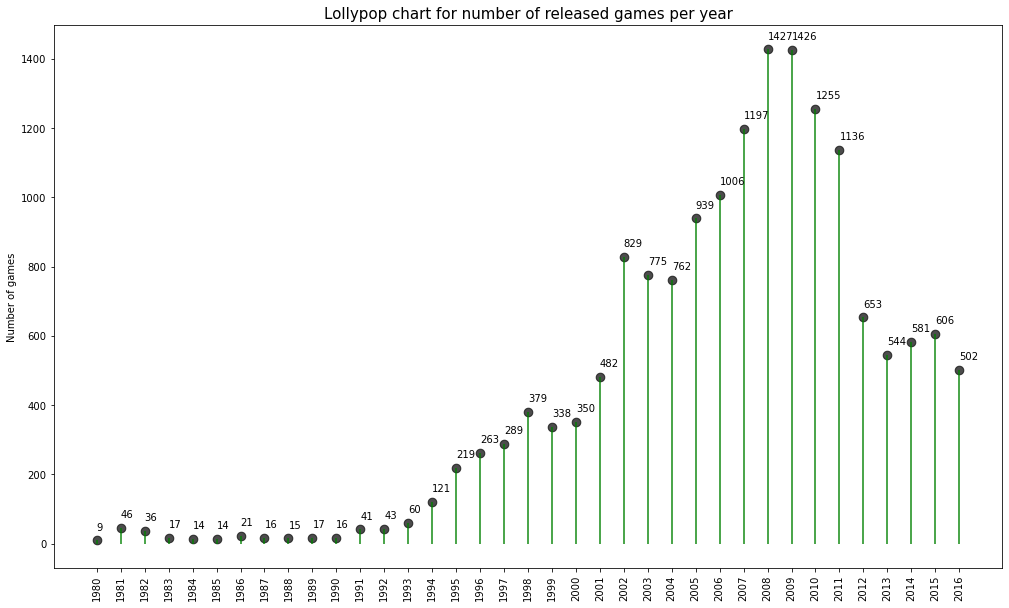

In [74]:
fig, ax = plt.subplots(figsize=(17, 10))

ax.vlines(x=year_grouped['year_of_release'], ymin=0, ymax=year_grouped['name'], color='green', alpha=0.7, linewidth=2)
ax.scatter(x=year_grouped['year_of_release'], y=year_grouped['name'], s=75, color='black',alpha=0.7)

ax.set_title('Lollypop chart for number of released games per year', fontdict={'size':15})
ax.set_ylabel('Number of games')
ax.set_xticks(year_grouped['year_of_release'])
ax.set_xticklabels(year_grouped['year_of_release'],rotation=90)

for row in year_grouped.itertuples():
    ax.text(row.year_of_release, row.name+30, s=round(row.name,2))
plt.show()

<b>Conclusion</b>
<br> On the plot we observe a slow rise in the number of releases from 1994, getting more notable in 2002. Then we can clearly differentiate the top 2 years with the greatest numbers of games releases, being 2008 and 2009. In 2010-2011 there was a slightly lower number of releases, and there's a significant drop in 2012, which corresponds with the economical crisis. The drop in sales for 2016 can be explained with incomplete data, as it is the current year, but overall from 2014 there's a slow growth in the number of released games.

<a id="platforms"></a>
### Variety of sales per platform

Now let's check how sales vary per platform.

In [75]:
sales_grouped = data[['platform', 'total_sales']].groupby(['platform']).sum().sort_values(by='total_sales').reset_index()
sales_grouped

,platform,total_sales
0,PCFX,0.03
1,GG,0.04
2,3DO,0.10
3,TG16,0.16
4,WS,1.42
5,NG,1.44
6,SCD,1.86
7,DC,15.95
8,GEN,28.35
9,SAT,33.59


The leader seems to be PS2 with 1233.56 million dollars, followed by X360 with 961.24 million dollars, and very close to it PS3 - 931.34 million dollars. Overall we can see that there's a huge gap between the lowest total income being PCFX with 0.03 and PS2 with 1233.56. It is probably related to years when those platforms were relevant, as we saw it really depends on the year how many games were released. 

To visualize this data we need to use horizontal bars, as this is categorical data, and there are too many categories for a pie chart or vertical bars. On the other hand, the difference between low revenue and high revenue is huge, so we need to use the normalization method. As such, to put all the variables on the same scale we'll use z-score, i.e. substracting the mean from the value and dividing by std.

In [76]:
sales_grouped['z-sales'] = (sales_grouped['total_sales'] - sales_grouped['total_sales'].mean()) / sales_grouped['total_sales'].std()
sales_grouped

,platform,total_sales,z-sales
0,PCFX,0.03,-0.826577
1,GG,0.04,-0.826548
2,3DO,0.10,-0.826373
3,TG16,0.16,-0.826199
4,WS,1.42,-0.822536
5,NG,1.44,-0.822477
6,SCD,1.86,-0.821256
7,DC,15.95,-0.780292
8,GEN,28.35,-0.744240
9,SAT,33.59,-0.729006


As our z-score is ready, let's create a color column to make it easier for us to build the visualization:

In [77]:
sales_grouped['color'] = ['red' if x < 0 else 'green' for x in sales_grouped['z-sales']]
sales_grouped

,platform,total_sales,z-sales,color
0,PCFX,0.03,-0.826577,red
1,GG,0.04,-0.826548,red
2,3DO,0.10,-0.826373,red
3,TG16,0.16,-0.826199,red
4,WS,1.42,-0.822536,red
5,NG,1.44,-0.822477,red
6,SCD,1.86,-0.821256,red
7,DC,15.95,-0.780292,red
8,GEN,28.35,-0.744240,red
9,SAT,33.59,-0.729006,red


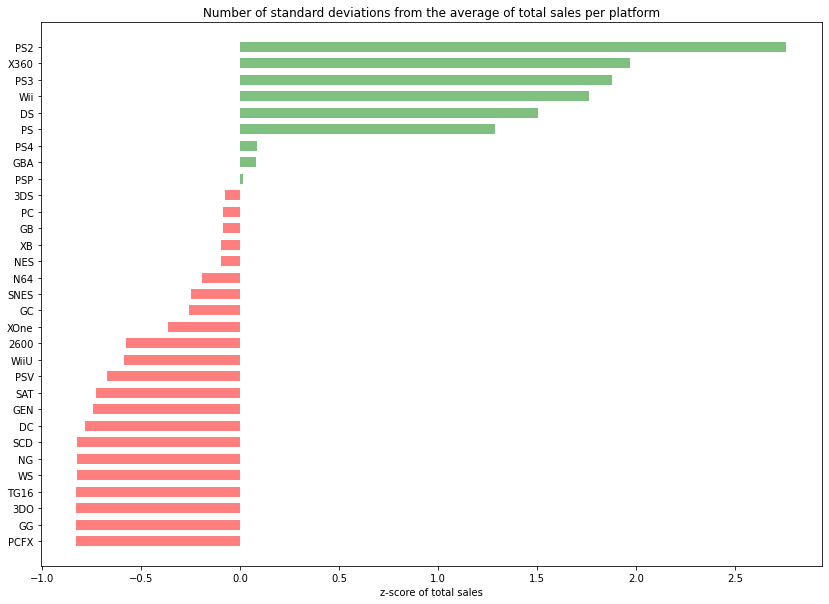

In [78]:
plt.figure(figsize=(14, 10))
plt.hlines(y=sales_grouped['platform'], xmax=sales_grouped['z-sales'], xmin=0, color=sales_grouped['color'], alpha=0.5, linewidth=10)

plt.title('Number of standard deviations from the average of total sales per platform')
plt.xlabel('z-score of total sales')

plt.show()

*Conclusion*: as we can see on the graph PS2 is greater than average by 2.5 stds, which is a huge number, it looks like an outlier comparing it to other platforms, though as we know the rule of thumb is that normal data lies within 3stds, so we can theoretically use it. x360 to PS group looks more normal and close to each other, they reach up to 2std.

On the other hand, we can clearly differentiate 'red' platforms, which have lower than mean values, hence are less than 0, although the difference is not as significant as in positive values, minimum z-score doesn't even reach -1. We will also take into consideration that with such an outlier as PS2 the mean was influenced by it, and also new platforms, that appeared on the market only recently won't be able to reach the heights in sales of 2008-2009 years, as we've seen previously while analyzing sales per years. 

For our next step at first we'll take top10 platforms.

<b>Revenue of chosen platforms per year</b>
<br>Next, we'll choose top10 platforms and we'll try to find out which platforms used to be popular in past, but now have 0 sales, and how long does it generally take for new platforms to appear and old ones to fade.

At first, we'll build pivot table:

In [79]:
platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']
data_pivot = data.query('platform in @platform_list').pivot_table(
    index='year_of_release', values='total_sales', columns='platform', aggfunc='sum').fillna(0)
data_pivot

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1994,0.00,0.00,0.00,6.03,0.00,0.00,0.00,0.00,0.00,0.00
1995,0.00,0.00,0.00,35.96,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,0.00,94.70,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,0.00,136.17,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,0.00,169.49,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,0.00,144.53,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.00,0.07,96.37,39.17,0.00,0.00,0.00,0.00,0.00
2001,0.00,0.00,61.53,35.59,166.43,0.00,0.00,0.00,0.00,0.00


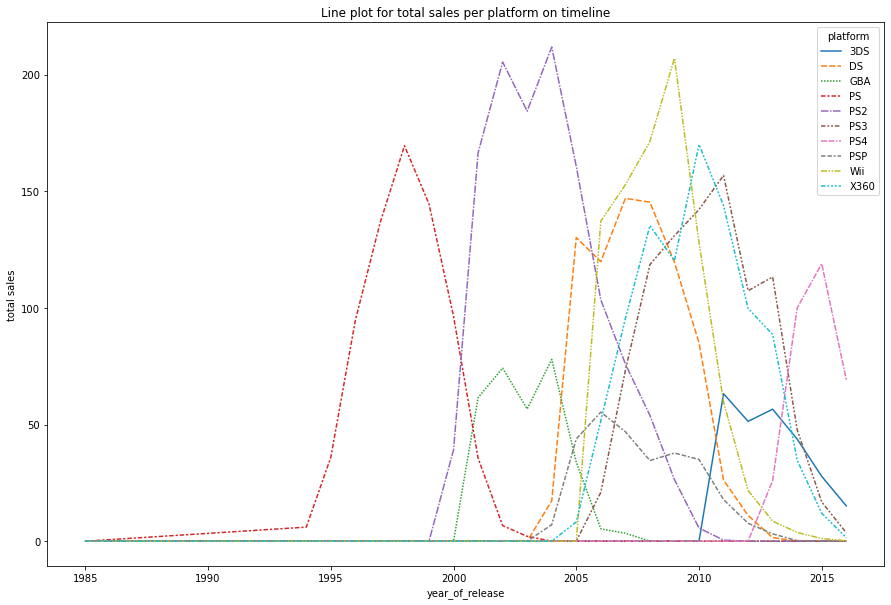

In [80]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=data_pivot)

plt.title('Line plot for total sales per platform on timeline')
plt.ylabel('total sales')

plt.show()

*Conclusion*: 
<br>First of all, we see that <b>PS</b> is the first successful platform on our timeline, it was popular in 1996-2000 years, and after that <b>PS2</b> took it's place as the leader, and remained successful for quite a long time, about 5 years, while having almost to none serious competition, hence it has the greatest total sales among all platforms. <b>GBA</b> and <b>PSP</b> had overall small sales that dropped to 0 before 2015, so we won't consider taking them fas a sample. At the same time when PS2's sales started to drop several other platforms became successful: first was <b>DS</b> reaching its first peak in 2005, followed and surpassed by <b>Wii</b> with a rapid rise in sales till 2009, then on a smaller scale <b>X360</b> and <b>PS3</b>, which reached their peaks in 2010 and 2011 respectively. The most recent favorite is <b>PS4</b> with a peak in 2015. Lastly, we have <b>3DS</b> appearing on the market in 2010 and reaching it's first peak in 2011, and second in 2013, though after that its sales started to drop and from the beginning its sales didn't reach the height of other platforms.

From our plot we can see that usually platforms rapidly raise their sales in the first year of it's release, also it takes more or less 2 years to reach the first peak in sales. It can also be considered a norm to have a slight drop and then another peak for the platforms. Probably that depends on the game releases and popularity of other platforms. Same for reaching 0 sales, as rapid as the rise was, the drop is also fast. Platforms compete with one another, and often drop in sales of one platform corresponds with the rise of another one, which also happens in more or less 2 years time. Typical lifetime of a successful platform seems to be about 5-6 years, exception being PS2, which lived for almost 10 years, but didn't have strong competitors till its later years.

As we know from our analysis of total sales per year of release, our top5 was 2007-2011 years and at the same time it means we had most profitable platforms in this period, but we need to take into account that this period isn't suitable to make predictions for 2017, as the platforms that used to be popular in these years already dropped their sales almost to 0. For the next analysis we'll take 2013 to 2016 years.

In [81]:
new_data = data.query('year_of_release >= 2013')
new_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,9.7,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,9.7,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,9.7,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16432,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16436,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01


In [82]:
new_data['platform'].value_counts()

PS4     392
PSV     358
PS3     345
3DS     303
XOne    247
PC      189
X360    186
WiiU    115
PSP      67
Wii      23
DS        8
Name: platform, dtype: int64

In [83]:
new_pivot = pd.pivot_table(new_data, index='year_of_release', values='total_sales', columns='platform', aggfunc='sum', fill_value=0)
new_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


As we can see we automatically got read of non-relevant platforms that reached 0 sales to recent years. Next to analyze which platform are growing and which are shrinking, we'll want to calculate the difference between years and we'll create a hitmap.

In [84]:
dynamics=(new_pivot-new_pivot.shift(+1)).T
dynamics

year_of_release,2013,2014,2015,2016
platform,,,,
3DS,NaN,-12.81,-15.98,-12.64
DS,NaN,-1.54,0.00,0.00
PC,NaN,0.90,-4.76,-3.27
PS3,NaN,-65.49,-30.94,-13.22
PS4,NaN,74.01,18.90,-49.65
PSP,NaN,-2.90,-0.12,-0.12
PSV,NaN,1.31,-5.65,-2.00
Wii,NaN,-4.84,-2.61,-0.96
WiiU,NaN,0.38,-5.68,-11.75


We have NaN values in 2013 as there's no preceding year, it is still ok for the research, as the most recent years are of interest to us.

In [85]:
dynamics = dynamics[[2014, 2015, 2016]]

Text(0.5, 1.0, 'Hitmap of sales dynamics in 2014-2016 years per platform\n')

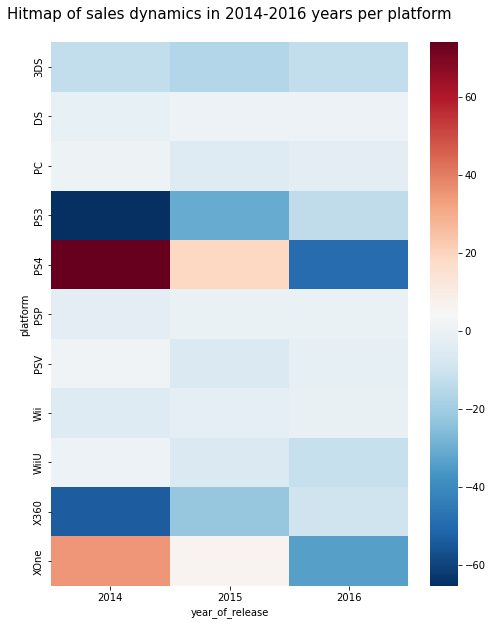

In [86]:
plt.figure(figsize=(8,10))
sns.heatmap(dynamics, cmap='RdBu_r')
plt.title('Hitmap of sales dynamics in 2014-2016 years per platform\n', fontdict={'size':15})

*Conclusion*: again, considering 2016 doesn't have all the data as it is the current year, we'll take a look at 2014 and 2015 years. Most of the platforms are shrinking, except for 2: PS4 and XOne. PS4 is still the most prominent one, with it's rapid growth in 2014, and continuing growth, although a bit slower, in 2015, still comparing it to XOne, it's growth is the most promising. Taking into account our previous analysis of platforms' growth, and the longevity and popularity of PS platforms, it looks like PS4's revenue can continue to rise in next years. It is best fit for our next steps of analysis. But for comparison we'll also take XOne.

<b>Global sales of all games per platform</b>

Our next step is taking a look at the differences in sales for various games. For that purpose we'll build boxplot chart using seaborn library.

Before that we'll update our new_data df, as we don't need 2013 year anymore.

In [87]:
new_data = data.query('year_of_release >= 2014')
new_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,9.7,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.2,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16432,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16436,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01


In [88]:
sample = new_data.query('platform == ("PS4", "XOne")')
sample

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,9.7,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.2,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Unknown,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,8.3,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16359,Sébastien Loeb Rally Evo,XOne,2016,Racing,0.00,0.01,0.00,0.00,6.3,8.2,E,0.01
16372,Rugby Challenge 3,XOne,2016,Sports,0.00,0.01,0.00,0.00,NaN,6.6,E,0.01
16374,ZombiU,XOne,2016,Action,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16389,Prison Architect,XOne,2016,Action,0.01,0.00,0.00,0.00,7.4,6.7,Unknown,0.01


In [89]:
sample_grp = sample.groupby(['platform', 'name'])['total_sales'].sum().reset_index()
sample_grp

,platform,name,total_sales
0,PS4,7 Days to Die,0.14
1,PS4,Adventure Time: Finn & Jake Investigations,0.10
2,PS4,Aegis of Earth: Protonovus Assault,0.02
3,PS4,Agatha Christie's The ABC Murders,0.02
4,PS4,Akiba's Trip: Undead & Undressed,0.11
...,...,...,...
599,XOne,Wolfenstein: The Old Blood,0.15
600,XOne,Worms: WMD,0.01
601,XOne,XCOM 2,0.04
602,XOne,ZombiU,0.01


Because of the outliers it's difficult to analyze the boxplots, so we'll set ylim.

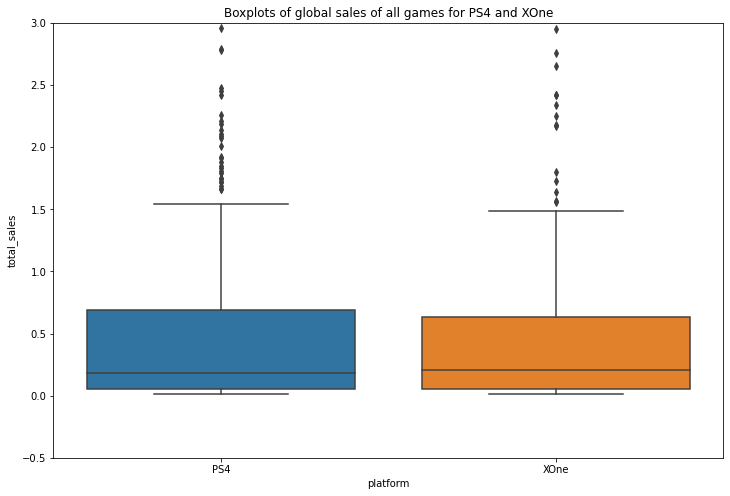

PS4 mean: 0.77         |     XOne mean: 0.62
PS4 std: 1.61          |     XOne std: 1.05
PS4 median: 0.18       |     XOne median: 0.20
PS4 N sales: 376.00    |     XOne N sales: 228.00
PS4 varies a lot
XOne varies a lot


In [90]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=sample_grp, x='platform', y='total_sales')
plt.ylim(-0.5, 3)

plt.title('Boxplots of global sales of all games for PS4 and XOne')

plt.show()

std_PS4 = sample_grp.query('platform == "PS4"')['total_sales'].std()
std_XOne =  sample_grp.query('platform == "XOne"')['total_sales'].std()
mean_PS4 = sample_grp.query('platform == "PS4"')['total_sales'].mean()
mean_XOne = sample_grp.query('platform == "XOne"')['total_sales'].mean()
median_PS4 = sample_grp.query('platform == "PS4"')['total_sales'].median()
median_XOne = sample_grp.query('platform == "XOne"')['total_sales'].median()
n_PS4 = sample_grp.query('platform == "PS4"')['name'].count()
n_XOne = sample_grp.query('platform == "XOne"')['name'].count()

print('PS4 mean: {:.2f}         |     XOne mean: {:.2f}'.format(mean_PS4, mean_XOne))
print('PS4 std: {:.2f}          |     XOne std: {:.2f}'.format(std_PS4, std_XOne))
print('PS4 median: {:.2f}       |     XOne median: {:.2f}'.format(median_PS4, median_XOne))
print('PS4 N sales: {:.2f}    |     XOne N sales: {:.2f}'.format(n_PS4, n_XOne))
if std_PS4 / mean_PS4 > 1:
    print("PS4 varies a lot")
else:
    print('PS4 is centered around average')
if std_XOne / mean_XOne > 1:
    print("XOne varies a lot")
else:
    print('XOne is centered around average')

*Conclusion*: As we can see in each case data varies a lot, which means that it really depends on the game how much income it will bring. This conclusion also matches with the number of outliers that are visible if we remove ylim, there are so many and such extreme ones that our plots turn into flat pancakes.
We can also see that there's a huge difference between mean and median(e.g. PS4 mean 0.77 and PS4 median 0.18, and we're talking about millions of dollars), telling us that mean is influenced by outliers.
Other conclusions from this plot:
* XOne median is slightly bigger than PS4's, most likely the reason is that there are fewer games released for this platform, and those released are more expensive ones.
* Half of the games have brought up to about 0.2 million dollars for last 2.5 years.
* 25% of games have brought up to 0.7 million dollars in recent years.
* 20% of games have brought up to 1.5 million dollars in recent years, PS4 only slightly succeeding XOne.
* Last 5% of data, which can be considered outliers, has brought more than 1.5 million dollars.

Overall there's no significant difference in how much games bring income depending on platform. The most significant difference is the popularity of the platform itself and how many games are released for said platform.

<a id="scores"></a>
### Influence of user and critic scores on sales per platform

For our next step we'll try to analyze how user and critic score affect sales for a popular platform, we'll take PS4 for our analysis. Further in the analysis we'll need to reuse this code, so we'll create a function for building a scatterplot and calculating the correlation between reviews and sales per chosen platform.

In [91]:
def score_influence(platform_name):
    sample_score = new_data[new_data['platform'] == platform_name]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(sample_score['critic_score'], sample_score['total_sales'], color='red', alpha=0.3, label='critic score')
    ax.scatter(sample_score['user_score'], sample_score['total_sales'], color='green', alpha=0.3, label='user score')

    ax.legend()

    ax.set_title('Correlation between user score and critic score with total sales for {}'.format(platform_name))
    ax.set_xlabel('Scores')
    ax.set_ylabel('Total sales')

    plt.show()

    print(sample_score[['critic_score', 'user_score', 'total_sales']].corr())

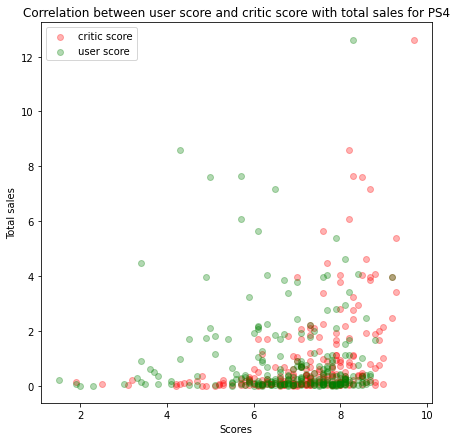

              critic_score  user_score  total_sales
critic_score      1.000000    0.544478     0.403470
user_score        0.544478    1.000000    -0.040386
total_sales       0.403470   -0.040386     1.000000


In [92]:
score_influence('PS4')

*Conclusion*: As we can see from the plot and correlation matrix, critic score does have positive correlation, on a weaker side. It can somewhat be considered for making predictions. On the other hand user score is close to 0. Why is that?

Our hypothesis is that a gamer will most probably read the critic review of the game before purchasing it and will trust it more, user review however is written after the game was purchased, hence it's lack of influence over the sales of the games.

### Comparing sales of games on different platforms

Now let's take a list of platforms that were somewhat popular in recent years to compare our results from the previous task.

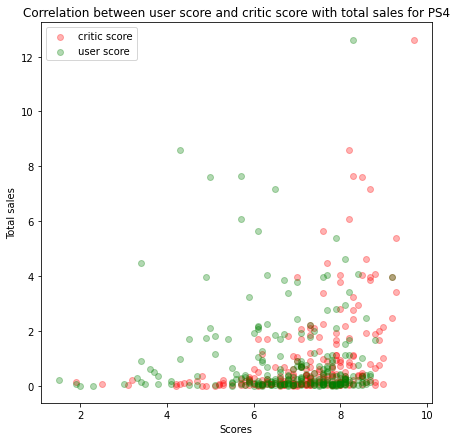

              critic_score  user_score  total_sales
critic_score      1.000000    0.544478     0.403470
user_score        0.544478    1.000000    -0.040386
total_sales       0.403470   -0.040386     1.000000
---------------------------------------------------------------------------------------


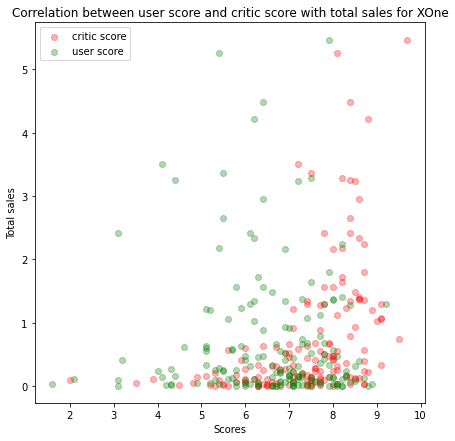

              critic_score  user_score  total_sales
critic_score      1.000000    0.438262     0.428981
user_score        0.438262    1.000000    -0.071759
total_sales       0.428981   -0.071759     1.000000
---------------------------------------------------------------------------------------


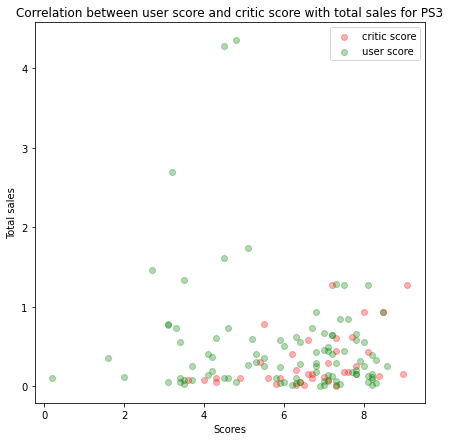

              critic_score  user_score  total_sales
critic_score      1.000000    0.693445     0.446575
user_score        0.693445    1.000000    -0.166761
total_sales       0.446575   -0.166761     1.000000
---------------------------------------------------------------------------------------


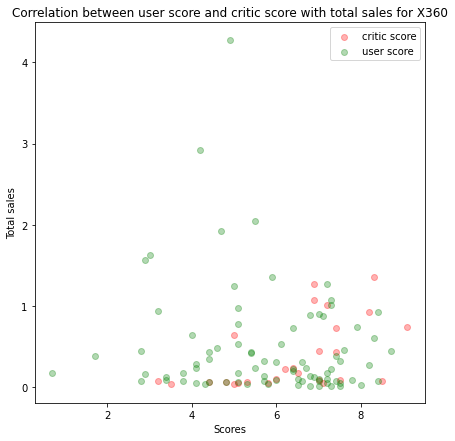

              critic_score  user_score  total_sales
critic_score      1.000000    0.625309     0.525723
user_score        0.625309    1.000000    -0.138445
total_sales       0.525723   -0.138445     1.000000
---------------------------------------------------------------------------------------


In [93]:
platforms_listed = ['PS4', 'XOne', 'PS3', 'X360']

for name in platforms_listed:
    score_influence(name)
    print('---------------------------------------------------------------------------------------')

*Conclusion*: As we see the correlation has same logic as we previously saw for PS4: critic score has positive weak correlation with prices, while user score has no correlation. XOne and PS4 have most similar results.

<a id="genres"></a>
### Genres

Next let's take a look at general distribution of genres. It is categorical data so we'll need a bar plot to better visualize it.

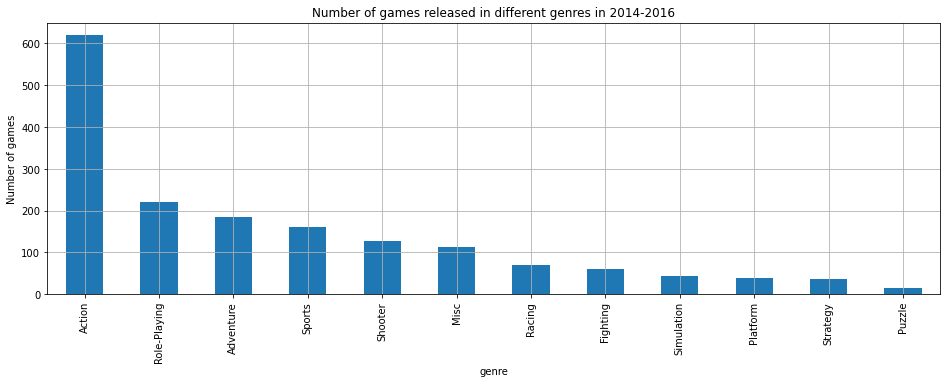

In [94]:
new_data['genre'].value_counts().plot(kind='bar', grid=True, figsize=(16, 5))
plt.xlabel('genre')
plt.ylabel('Number of games')
plt.title('Number of games released in different genres in 2014-2016')

plt.show()

*Conclusion*: as we can see in recent years 'action' is the most popular genre among games, with about 610 games in this genre, followed by 'Role-Playing' with huge difference - it's only about 220 games, and then 'Adventure', with about 190 games. The rarest genre nowadays is 'puzzle', having only about 10 games.

Next let's take a look which of these genres are the most profitable ones.

In [95]:
genres_grouped = new_data.groupby(['genre'])['total_sales'].agg(['sum', 'mean', 'median', 'count']).reset_index().sort_values(by='sum',ascending=False)
genres_grouped

,genre,sum,mean,median,count
0,Action,199.36,0.322068,0.090,619
8,Shooter,170.94,1.335469,0.515,128
10,Sports,109.48,0.680000,0.180,161
7,Role-Playing,101.44,0.459005,0.110,221
3,Misc,37.55,0.332301,0.090,113
2,Fighting,28.22,0.470333,0.125,60
6,Racing,27.52,0.398841,0.090,69
4,Platform,18.09,0.476053,0.140,38
1,Adventure,17.55,0.094865,0.030,185
9,Simulation,13.13,0.298409,0.100,44


As there are platforms with less than 50 games released in recent years, we can't analyze them.

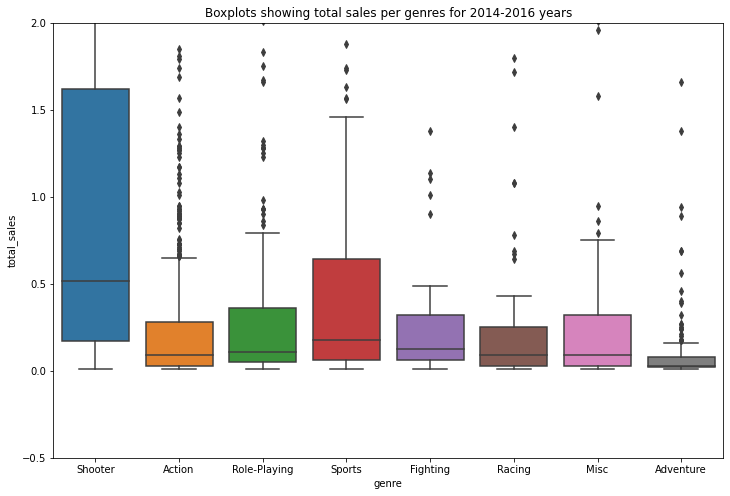

In [96]:
genres_listed = ['Strategy', 'Simulation', 'Puzzle', 'Platform']
plt.figure(figsize=(12, 8))
sns.boxplot(data=new_data.query('genre not in @genres_listed'), x='genre', y='total_sales')
plt.ylim(-0.5, 2)

plt.title('Boxplots showing total sales per genres for 2014-2016 years')

plt.show()

*Conclusion*: we looked at the general distribution of genres and saw that action is the most popular genre among games, but even though its sales have the highest total sales in recent years, its median is one of the lowest, which tells us that the demand for variety in this genre is high, but the price of the games is probably low, so they win by quantity. On the other hand shooters have the highest median, and looking at the total sales in recent years, they are second highest, even though the quantity of games in this genre is mediocre: 5th place out of 8 genres, with about 120 games. Perhaps it has something to do with multiplayer, as usually shooters are played in groups of friends. Genre that brings the least revenue is adventure, although in number of games it is more present than shooters. 

Overall it is hard to tell whether genre influences sales or it is another factor. We consider that there's a high chance that group-oriented multiplayers can have significant influence on total sales, as it will be a game one wants to play with their friends. Usually, such multiplayers are shooters, but it can be MMORPG like Lineage, which we don't know for sure is presented in Role-Playing genre in this dataset or not. Other famous examples are GTA which - Action-Adventure, Minecraft - with unique genres like sandbox and survival. This leads us to another thought: usually games have a mix of genres, but as for the data that we have there's only one genre presented, and we don't know what was the logic of choosing one genre out of several. Perhaps 'action' is most frequent because this genre is very compatible with many others. If we could we would have consulted our team on this topic.

Overall, we consider that from this research it is hard to make trustable conclusions about genre. It is best to make an additional research on this topic.

<a id="conclusion3"></a>
### Conclusion

In this step we've analyzed our data from different perspectives:

1) We've looked at how many games were released in different years, and found out that the highest amount of games was released in 2007-2011 years with 2008-2009 as absolute leaders with 1427 and 1426 releases respectively. Alas, this period isn't relevant for our research as it won't permit us to make predictions about 2017 year.

2) We've looked at how sales varied from platform to platform and found that PS2 was absolutely the most popular and long-lived platform among all others, with its sales being 2.5 stds from average sales, but it died already by 2010 and isn't suitable for the research. We've analyzed typical lifetime of a platform, and saw that for the most successful ones it is more or less 5-6 years, with rapid rise in sales in the year of it's release. Till 2010 there were no strong competitors to PS2, which probably also explains its longevity. The older platforms usually start to fade the same time a new successful platform appears. Hence, there even PS2 reached 0 values in 2011 as there were too many other successful platforms.

Concluding these two steps we've determined to take only most recent years, as if there is a promising platform, its lifetime will probably be only about 5-6 years. We've decided to take 2014-2016 years, taking into account that the data we have for 2016 isn't full as it is a current year.

3) Next, we wanted to determine which platforms are leading in sales, and which ones are growing or shrinking to select several potentially profitable platforms. For that purpose we've built a heatmap based on z-scores of sales per platform, as the data varied too much. We were able to immediately tell that there are only 2 platforms with rising revenue in 2014-2016 years: PS4 and XOne, all other platforms are already shrinking. It's important to note that PS4 already succeeds XOne greatly and looks like the most profitable one.

4) We've looked at the global sales of all games, broken down by platform by building boxplots for relevant platforms, being PS4 and XOne. We clearly saw that averages don't differ too much, PS4 being only slightly greater than XOne. It lead us to conclusion that PS4 is more successful not because a game brings more sales on this platform, but because there are more games released for this platform.

5) We've looked at how user and critic reviews affect sales for PS4. We've built scatterplot and correlation matrix and saw that critic score does have weak positive correlation with total sales, while user score's correlation is almost 0. In our opinion, it sounds logical, as before making a purchase of a game released this year user can hear or check professional reviews and then decide to buy or not to buy a game based on it. User leaving a review is a part that comes after the user purchased the game. Although there can be other users' opinions on the Net, we can only analyze those posted officially (i.e. not comments on forums or Reddit etc). We've compared our results to other platforms and it turned out that there's same somewhat weak positive correlation between critic score and total sales, and almost 0 in case of user score.

6) We've looked at the general distribution of games by genre, which turned out to be interesting, though not very reliable in terms of making predictions. First of all Action was the most popular genre with highest total sales. But at the same time it turned out to be one of the least profitable genres among others. It looks like there's a demand on diversity of such games, or production of these games is cheaper, it takes first place only by quantity. On the other hand Shooter turned out to be most profitable, with median half a million per game. We consider that other factors may have more influence on sales of a game than genre: like a multiplayer, which is a popular type for a Shooter. Besides, usually games are of several genres, and we don't know what was the selection method for our dataset to have only one. If so, Action can look most frequent while part of those games have other additional genres. Overall, there definitely is a chance that genre influences sales, but it is too hard to determine with this dataset.

<a id="user-profile"></a>
## User profiles

For each region we're going to create a user profile, then we'll determine next things:
- The top five platforms. We'll describe variations in their market shares from region to region.
- The top five genres. We'll explain the difference.
- We'll answer the question whether ESRB ratings affect sales in individual regions

As at this step we're working with categorical data, and we'll need each time to create a grouped df for sales in each region for different categories, we can create a single function for all of them.

We're creating a function that takes two parameters: df and name of the category we're comparing. We could have created separate user profiles for each region describing all the categories, but in our opinion it is easier to compare them this way.

In [97]:
def grouped_pie(data, name):
    sales_dict = {'na_sales':('na', 'North America'), 
                  'eu_sales':('eu', 'Europe'), 
                  'jp_sales':('jp', 'Japan')}
    
    for key in sales_dict.keys():
        df = data.groupby([name])[key].agg(['sum', 'mean']).reset_index().sort_values(by='sum',ascending=False).head()
    
        plt.figure(figsize=(7, 7))
        colors = sns.color_palette('pastel')[0:len(df)]

        plt.pie(df['sum'], labels=df[name], colors = colors, autopct='%.1f%%')
        plt.title('Sales per {} in {}'.format(name, sales_dict[key][1]))
        plt.show()
        
        print(df)
        print('-------------------------------------------------------------------')

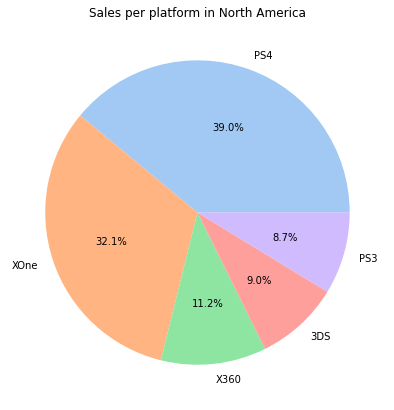

  platform    sum      mean
3      PS4  98.61  0.262261
9     XOne  81.27  0.356447
8     X360  28.30  0.254955
0      3DS  22.64  0.106792
2      PS3  22.05  0.100685
-------------------------------------------------------------------


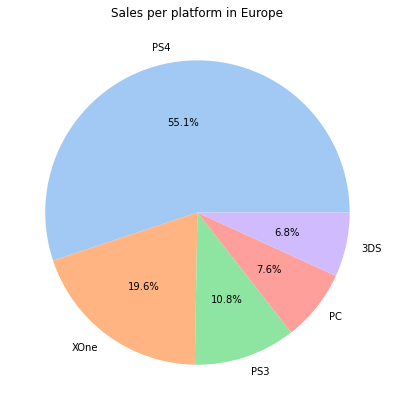

  platform     sum      mean
3      PS4  130.04  0.345851
9     XOne   46.25  0.202851
2      PS3   25.54  0.116621
1       PC   17.97  0.119007
0      3DS   16.12  0.076038
-------------------------------------------------------------------


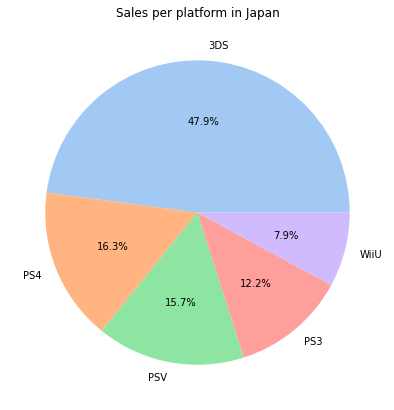

  platform    sum      mean
0      3DS  44.24  0.208679
3      PS4  15.02  0.039947
5      PSV  14.54  0.049288
2      PS3  11.22  0.051233
7     WiiU   7.31  0.100137
-------------------------------------------------------------------


In [98]:
grouped_pie(new_data, 'platform')

*Conclusion*:
* `PS4`: is most profitable in Europe with 55% of all sales on this market. It is also most popular platform in North America, though it brings in only 39% of the revenue. Interesting enough is that in Japan it isn't the most profitable platform, it only takes the second place with 16.3% of total sales.

* `XOne`: is second most popular platform in Europe and in North America, being completely absent in top5 in Japan. We can see that XOne is more popular in NA than in Europe, it's part is only slightly smaller than PS4's, being 32.1% of total sales. Which tells us that in North America XOne and PS4 have similar popularity among users. At the same time it's much less popular in Europe, only 19.6%.

* `X360`: is in top5 only in North America, take third place in it's share of total income with 11.2%.

* `3DS`: is the most popular platform in Japan with almost half of total sales - 47.9%! On the other hand it is much less popular in North America and Europe, with 9.0% and 6.8% respectively.

* `PS3`: among all regions it's most popular in Japan, still it's only 4th place out of top5 with 12.2% of total income. It has even smaller parts in Europe and North America, 10.8% and 8.7% respectively. It seems that users in Europe really like PlayStations, even here, though not by much, it is more popular than in North America.

* `PC`: is a platform presented in top5 only in Europe, only with 7.6% of total sales. 

* `PSV`: another platform presented only in Japan's top5 with whole 15.7% of total sales.

* `WiiU`: is again a platform presented only in Japan's top5, with 7.9% share of total sales.

<b>Genre</b>

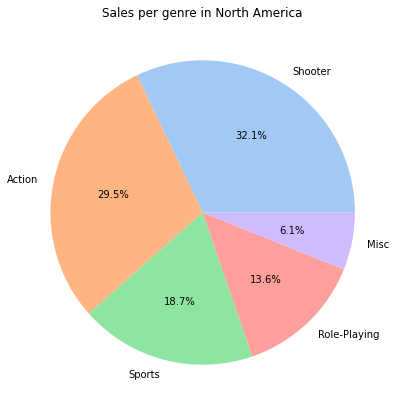

           genre    sum      mean
8        Shooter  79.02  0.617344
0         Action  72.53  0.117173
10        Sports  46.13  0.286522
7   Role-Playing  33.47  0.151448
3           Misc  15.05  0.133186
-------------------------------------------------------------------


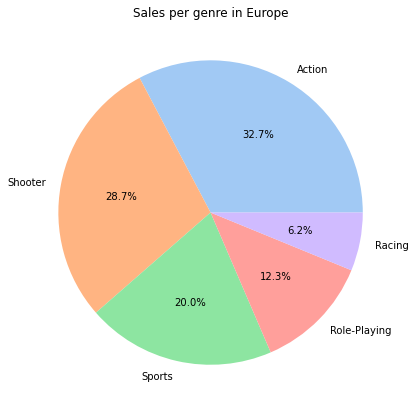

           genre    sum      mean
0         Action  74.68  0.120646
8        Shooter  65.52  0.511875
10        Sports  45.73  0.284037
7   Role-Playing  28.17  0.127466
6         Racing  14.13  0.204783
-------------------------------------------------------------------


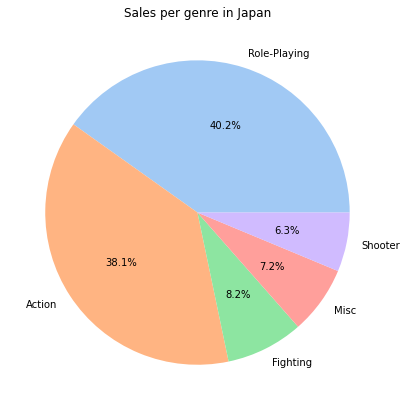

          genre    sum      mean
7  Role-Playing  31.16  0.140995
0        Action  29.58  0.047787
2      Fighting   6.37  0.106167
3          Misc   5.61  0.049646
8       Shooter   4.87  0.038047
-------------------------------------------------------------------


In [99]:
grouped_pie(new_data, 'genre')

*Conclusion*:

* `Shooter`: is the most popular genre only in North America, with 32.1% of all sales, taking second place in top2 in Europe with 28.7%, and only 6.3% in Japan.

* `Action`: is the most popular in Europe with 32.7% of total sales in this genre, and second most popular in North America and Japan, with 29.5% and 38.1% respectively. We can see that even though action isn't the most popular genre in Japan, it is still much more popular thn in other regions as Japanese seem to be more consistent in their preferences.

* `Sports`: is third most popular genre in both North America and Europe, with 18.7% and 20.0% respectively. It is absent in Japan's top5 popular genres. 

* `Role-Playing`: is the most popular genre in Japan with whole 42.1% of total sales. On the other hand in North America and Europe it takes only 4th place in top5 with 13.6% and 12.3% respectively.

* `Misc`: is genre presented in NA and Japan's top5, but absent in Europe, with 6.1% and 7.2% respectively.

* `Racing`: is a genre presented in top5 of Europe only with 6.2% of all sales.

* `Fighting`: is a genre presented only in Japan's top5 and taking 3d place in popularity with 8.2% of total sales.

<b>ESRB ratings per region

Before proceeding, let's check how many ratings we have for the last years.

In [100]:
new_data['rating'].value_counts()

Unknown    732
M          274
T          272
E          223
E10+       188
Name: rating, dtype: int64

Luckily we have exactly 5 categories, so we don't need to make changes in our function.

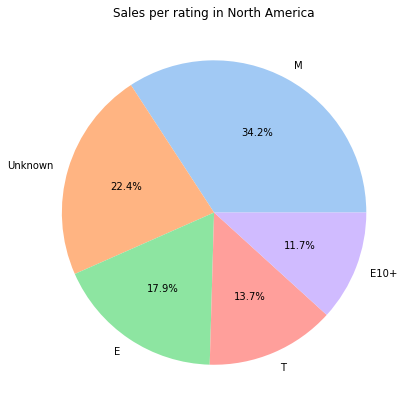

    rating    sum      mean
2        M  97.15  0.354562
4  Unknown  63.66  0.086967
0        E  50.94  0.228430
3        T  38.96  0.143235
1     E10+  33.35  0.177394
-------------------------------------------------------------------


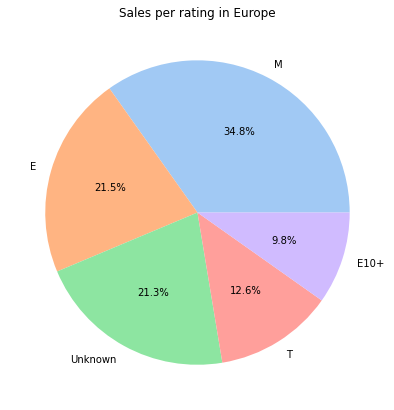

    rating    sum      mean
2        M  94.25  0.343978
0        E  58.22  0.261076
4  Unknown  57.62  0.078716
3        T  34.07  0.125257
1     E10+  26.52  0.141064
-------------------------------------------------------------------


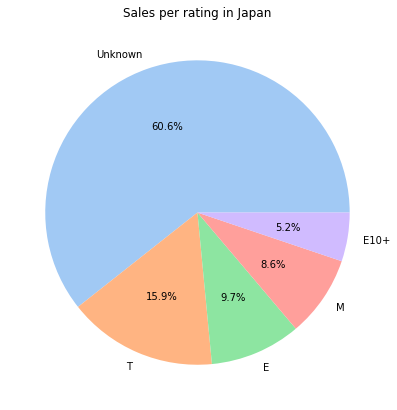

    rating    sum      mean
4  Unknown  56.45  0.077117
3        T  14.78  0.054338
0        E   9.00  0.040359
2        M   8.04  0.029343
1     E10+   4.82  0.025638
-------------------------------------------------------------------


In [101]:
grouped_pie(new_data, 'rating')

*Conclusion*:

* `Unknown`: appears in great parts of total sales in all regions, but most of all in Japan, taking whole 60.6% of total sales. To explain that we need to have a bit better understanding of this value's origin. As we previously stated, ESRB is an organization of gaming ratings in USA and Canada. That means that games released in Japan, for example, can have another rating system. Checking on Wikipedia we see that there are actually several content rating systems in Japan. The same goes for Europe. Overall, this can possibly hint us at the origin of the games. This analysis can't be considered as complete, we can only say that 40% of top5 most profitable ratings in Japan are from games that have received ESRB ratings. Same goes for other regions, North America - 22.4% of unknown ratings, Europe - 21.3% of unknown ratings. It also sounds logical that not all the games played in North America have same origin.

https://en.wikipedia.org/wiki/Video_game_content_rating_system#Japan

https://en.wikipedia.org/wiki/Video_game_content_rating_system#Europe


Overall we consider this data insufficient to make conclusions for Japan based on it, hence we'll analyze only North America and Europe:

* `M` or mature (intense violence, blood, strong language, usually for 17+): is the most popular rating in NA and Europe, taking almost same shares of total income among top5, 34% among top5 in both NA and Europe with 97 million and 94 million of sales respectively. If we're looking at averages, then games having this rating are also most profitable, about 0.4 million and 0.3 million per game in North America and Europe respectively.
* `E` or everyone (comic, mischief, mild lirycs): is second to mature in both Europe and North America, with 21.5% and 17.9% respectively.
* `T` or teenage (violence, suggestive themes, suitable for 13 and up): brought 39 millions in North America and 32 in Europe.
* `E10+` or everybody older than 10 (fantasy violence, mild language): is the least popular in top5, bringing 33 million in North America and 25 million in Europe. 

<a id="conclusion4"></a>
### Conclusion

To sum up our findings about preferences of users in different regions:

<b>Japanese user</b>:
<br>Is very different from European or American. Judging by preference of platforms, it's important for the user to have a mobile game platform. It can be related to difference in infrastructure and working conditions, as people tend to spend hours to get to their work/university, having to live far from it, also they tend to have longer office hours, in short spend more time outside. Hence we have 3 portative platforms in top5: 3DS, WiiU and PSV, with 3DS being the most popular out of all the platforms, with almost half of all  games purchased for this platform, 48%.

Japanese user is more consistent in their preference of game genres: two most popular genres are Role-Playing and Action, that make together almost 80% of all sales in top5 genres. Other 3 genres in top5 are: Fighting, Misc and Shooter. Role-Playing games on average bring more income than other genres in this region - 0.14 million per game, it's total sales are 31 million. Action on the other hand, while bringing almost 30 millions, on average bring much less income: 0.05.

We can not make judgments about most frequent ratings for this user, as 60% of ratings in top5 sales remain unknown. It probably means that often Japanese users play games of origin other than Canada or America.

<b>European user</b>:
<br>From the results of our study we see that European user prefers Play Station over other platforms, as the most profitable platform is PS4 with 55% of total sales in 2014-2016 years, and additional 11% for PS3. Second best option in this region is XOne, but only with about 20% of total sales among top5. Other platforms in top5 are: 3DS and PC.

Shooter and Action games interest European user the most, taking about 60% of total sales in top5 genres with similar shares of 29% and 33% respectively. This genres alone have brought 140 millions dollars in 2014-2016 years. Although Shooter has brought slightly less income than Action, it is important to note that on average one Shooter game brings almost 5 times more income than Action game. The current difference in income can be explained with number of Shooter games which is less than those in Action. Other popular genres are: Sports, Role-Playing and Racing. If we compare only averages among genres than our top5 will be presented in next order: Shooter 0.5, Sports 0.3, Racing 0.2, Role-Playing 0.1 and Action 0.1.

Mature is the most frequent rating in 2014 years, bringing 94 million dollars. On average Mature game brings in more income than all other ratings, second-best being Everyone, which brought 58 million.

<b>North American user</b>:
<br>Our study shows that in this region XOne shows itself more competitive to PlayStation: PS4 and XOne have relatively similar shares of total sales: 39% and 32% respectively. Other popular platforms are X360, 3DS and PS3 with relatively similar shares: 11%, 9% and 9%.

Shooter and Action are the favorites in this region, Shooter's sales slightly bigger than Action's: 32% of top5 with 79 millions, and 30% with 72 million respectively. But if we look at the averages, Shooter is most profitable of all genres with 0.6 million per game, while Action is only 0.1. Second most profitable genre is Sports with 0.3 average sales per game in this region, although it looks less popular - 19% from our top5.

Same as for European user Mature seams to be most popular and profitable rating.

<a id="hypotheses"></a>
## Hypotheses testing

As a last step in our research we'll test several hypotheses:

—Average user ratings of the Xbox One and PC platforms are the same.
<br>—Average user ratings for the Action and Sports genres are different.

Usually in business we're searching for every tiny opportunity to rise profits worth investigation, so sometimes alpha can be set 10%. So this is what we'll do.

<b>Average user ratings of the Xbox One and PC platforms</b>:
* H0: there's no difference in average user ratings of Xbox One and PC Platforms.
* H1: there's difference in average user ratings of Xbox One and PC Platforms.

<b>Average user ratings for the Action and Sports genres</b>:
* H0: there's no difference in average user ratings for the Action and Sports genres.
* H1: there's difference in average user ratings for the Action and Sports genres.

In [102]:
xone = new_data.query('platform == "XOne"')
pc = new_data.query('platform == "PC"')

Taking into account that we have a lot of NaN values in `user_score` we need to drop them from our samples.

In [103]:
xone_sample = xone['user_score'].dropna()
xone_sample

165      7.9
179      5.4
241      6.4
269      6.2
372      4.1
        ... 
16273    6.8
16326    6.0
16359    8.2
16372    6.6
16389    6.7
Name: user_score, Length: 167, dtype: float64

In [104]:
pc_sample = pc['user_score'].dropna()
pc_sample

455      3.9
1515     5.4
1710     7.9
2273     5.7
2746     5.9
        ... 
16187    8.3
16193    6.8
16239    7.9
16248    1.4
16421    7.6
Name: user_score, Length: 124, dtype: float64

Next we'll check the sizes of our samples:

In [105]:
print('Percentage:', len(xone_sample) / len(new_data))
print('N:', len(xone_sample))

Percentage: 0.09887507400828893
N: 167


In [106]:
print('Percentage:', len(pc_sample) / len(new_data))
print('N:', len(pc_sample))

Percentage: 0.07341622261693309
N: 124


In [107]:
action = new_data.query('genre == "Action"')
sports = new_data.query('genre == "Sports"')

In [108]:
action_sample = action['user_score'].dropna()
action_sample

42       8.3
165      7.9
230      8.1
294      6.3
303      4.9
        ... 
16273    6.8
16326    6.0
16381    8.5
16389    6.7
16421    7.6
Name: user_score, Length: 301, dtype: float64

In [109]:
print('Percentage:', len(action_sample) / len(new_data))
print('N:', len(action_sample))

Percentage: 0.17821195973949083
N: 301


In [110]:
sports_sample = sports['user_score'].dropna()
sports_sample

77       4.3
94       5.0
143      5.7
263      4.5
313      6.7
        ... 
15861    6.3
15883    8.8
15887    6.9
16248    1.4
16372    6.6
Name: user_score, Length: 127, dtype: float64

In [111]:
print('Percentage:', len(sports_sample) / len(new_data))
print('N:', len(sports_sample))

Percentage: 0.07519242155121374
N: 127


In [112]:
alpha = 0.1

For the mathematical confirmation of one of our hypotheses we're going to use Leven's test, as we compare the averages of two samples and it will help us to compare the variances, and the Student's T-test.

In [113]:
def user_score_ttest(sample1, sample2):
    
    pvalue_levene = st.levene(sample1, sample2).pvalue
    
    alpha = 0.05

    if pvalue_levene < alpha:
        eqvar = False
    else:
        eqvar = True
    
    if st.ttest_ind(sample1, sample2, equal_var=eqvar).pvalue < alpha:
        print('Reject H0: average of sample 1 is not equal to average of sample 2')
    else:
        print("Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same")

In [114]:
user_score_ttest(xone_sample, pc_sample)

Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same


In [115]:
user_score_ttest(action_sample, sports_sample)

Reject H0: average of sample 1 is not equal to average of sample 2


<a id="conclusion5"></a>
### Conclusion

*Conclusion*: 

1) We failed to reject null hypothesis stating that there's no difference in user scoring of games between Xbox One and PC platform. This tells us that from our data the chance that there's any difference in user ratings of a game depending on a platform being Xbox One or PC is almost impossible and if there are variations, then it's most probably a coincidence.
    
2) We can reject the null hypothesis stating that there's no difference in user rating depending on genre of a game being Action or Sports. This tells us that there's is a chance that user rating depends on genre of the game.
    
Overall the results tell us that user rating of games have tendency to depend more on the properties of the game itself, like genre, and less on the platform.

<a id="conclusion6"></a>
## Overall Conclusion

After evaluating the data from various perspectives we came to the next conclusions:

After the world's economic crisis in 2012 and rapid drop in number of released games, starting from 2014 we see that number of releases slowly rises. If no other crisis happens, it is expected that most probably this year and in 2017 we'll have growth in the number of games released. Based on this data we've proceeded with our analysis working with data from 2014-2016 years.

The 2 most profitable growing platforms in recent years are PlayStation4 and Xbox One with PlayStation4 in the lead. This platform is the leader in sales both in North America and in Europe, the difference being that it is much more popular in Europe than in North America. In 2014-2016 PS4 has brought 130 million dollars from the European region, and 98 million in the North American. Overall gamers of European region prefer PlayStation to all other platforms, while in North America Xbox One's total sales come closer to PS4's than in any other region: 81 million dollars.

After evaluating a typical lifetime of a platform we came to a conclusion, that most popular platforms live for 5-6 years, but when there's no strong competition, this lifetime has a chance to extend. At this moment, as we've mentioned earlier there are only 2 platforms still growing their sales: PS4 and XOne, both appared on the market at the same time, in 2013. Still it is important to note that appearing at the same time PS4 and XOne have very different levels of total sales, and it doesn't look like this tendency will change. So PS4 most probably will remain on top for next few years if there will be no new competitive platform on the market.

We've also checked how much influence user and critic score have over total sales of the game, and came to a conclusion that:
<br>1) most possibly user review of a game won't depend on a platform. 
<br>2) while critic score influences to some extent the total sales of a game, user score does not. 
<br>Overall there's more chance that a game that received positive assessment of professional game critics will have greater sales than one that wasn't welcomed by professionals.

After analyzing game genres we need to note that we can't know for sure whether the data that we have is portraying the reality well, as we've had only one genre per game, while in real-life situation a game usually has a mix of genres. More than that we consider it is best to conduct additional research on genres influence on sales taking into account a type of game, e.g. online multiplayer, RPG, FPS, MOBA etc. Still we want to present the results of analysis that we've conducted so far.
Among all genres Shooter is most profitable per game and Action is the one with greatest amount of total sales. Comparing the two, Shooter's average sales are 5 times greater than Action's, that can be explained with a fact that Action is the most frequent genre of all.

After analyzing user profiles of different regions (Europe, North America and Japan) we came to a conclusion, that while European and North American users are somewhat alike, Japanese user has different preferences. For example, we can clearly see how Japanese users prefer portable platforms to regular ones, which is probably explained by difference in a lifestyle, when Japanese stay more hours out from home and spend more hours at work. Their choice of games is also different from other regions, giving first place to Role-Playing games. We also can't make conclusions about most profitable content rating in Japan, as we've had too much missing data, telling us that most probably Japanese play games of diverse origin, that didn't receive rating from ESRB organization.

<b>Hypotheses testing</b>

* After testing a hypothesis about average user score for different platforms, comparing XOne and PC, being the same, we came to a conclusion, that the chance that there's difference in scoring a game depending on it's platform is very small, usually a coincidence. Platform has almost none influence on the level of satisfaction of a user, platform doesn't make a game better.

* After testing a hypothesis about average user score depending on genre of a game, we came to a conclusion, that unlike platform choice there's a high chance that genre does influence satisfaction level of a user.

Overall this means that first of all before choosing a game for advertisment it is important to pay attention to it's genre, critic reviews, and most possibly type.
We consider it is best to conduct an additional research about sales depending on genres and types of games.

<b>Recommendations for business</b>

We need to take into consideration the region of game's advertisment as users in Japan have very different preferences compared to Europe and North America. As such:

*Japan*: 
* most popular platforms are portative ones with preference for Nintendo platforms, the most popular being 3DS. On the other hand this platform is shrinking, so it is a best idea to advertise games for the second most popular choice being PS4 or a game for new portable Nintendo platform, when there's one. 
* genres that japanese users prefer are: Role-Playing and Action, which take up a very considerable amount of total sales. They have similar shares, so either of them is a good choice.
* from our analysis it is highly possible that Japanese users prefer games of non-american origins, as top-rating among games sold in this region is unknown, which most possibly tells that games didn't receive their rating by ESRB organization. It is our recommendation to take a deeper look at the origin of most profitable games in this region.

*North America & Europe*:
* PlayStation is the most popular choice, in recent years PS4 has highest total sales. Investing in a game oriented for this platform will be the best choice. 
* Shooter is the most profitable genre. 
* Mature is the most profitable rating among games sold in 2014-2016.

*All*:
* It is recommended to choose a game for advertising with positive professional reviews, also it can be a good idea to use these reviews for advertisment.
* It is recommended to make an additional research on game's type (MMORPG, RPG, FPS etc).